# Implementing a Support Vector Machine using Sequential Minimal Optimization and Python 3.5

[Support vector machines](https://en.wikipedia.org/wiki/Support_vector_machine) (SVMs) are a group of powerful supervised learning algorithms. They can take the form of classifiers (support vector classifiers, SVCs) or regressors (support vector regressors, SVRs). A support vector classifier seeks to find a decision boundary with the greatest margin of separation between the input classes. This is unlike a logistic regressor which simply finds any dividing boundary between classes within the feature space. If the training data are not linearly separable, a "soft-margin" (or regularized) version can be implemented that allows for misclassified samples. The output decision boundary can be linear, as it is with logisitc regression, or non-linear with the use of various kernels that map the input features to a higher-dimensional space. This is known as the "kernel trick" and can be a very powerful tool for finding unusual decision boundaries.

This notebook assumes the reader has basic knowledge of what a SVM is (if not, skim the Wikipedia article above) and will cover how to translate the mathematical concepts into a working example using Python. I highly recommend the introduction to SVMs found in the [lecture notes for Stanford's CS229](http://cs229.stanford.edu/materials.html) taught by Andrew Ng.

#### Disclaimer

There are several existing libraries designed specifically for solving the optimization problem(s) presented by SVMs such as [LIBLINEAR/LIBSVM](https://en.wikipedia.org/wiki/LIBSVM) and [CVXOPT](http://cvxopt.org/). These libraries should be favored over the implementation below, which is meant to be a personal reference or educational resource.

### Mathematical formulation

#### The primal form

A support vector classifier can be represented mathematically by

$$f(x) = w^T x - b$$

using the output $f(x)$ to determine the class label vector $y$

$$y = \begin{cases}1, & f(x) \ge 0 \\ -1, & f(x) \lt 0 \end{cases}$$

where $x$ is a feature vector, $w$ is a weight vector, and $b$ is a bias term. For SVMs, the convention is to use class labels $y \in \{-1, 1\}$. This function $f(x)$ represents the classifier's decision function. It looks similar to the problem posed by logistic regression, however with an SVM we don't want just any solution that will divide our data, we want the solution that will do so with the largest margin between our two classes (if possible). This introduces a constraint to our problem. What this ultimately means is that our optimization problem becomes

$$min_{w,b} \frac{1}{2}\left\lVert w \right\rVert^{2}$$

subject to

$$y^{(i)}(w^Tx^{(i)} - b) \ge 1,\;i = 1,...,m$$

where $m$ is the number of training examples, indexed by $i$. This formulation is known as the [*primal* formulation](https://en.wikipedia.org/wiki/Support_vector_machine#Primal_form) of the SVM optimization problem.

This formulation can be solved using existing quadratic programming solvers such as [CVXOPT](http://cvxopt.org/) and other methods (for example see [this paper [PDF]](http://is.tuebingen.mpg.de/fileadmin/user_upload/files/publications/neco_%5B0%5D.pdf)). However, there is another formulation of the problem that can be solved without using quadratic programming techniques.

#### The dual form
Using Lagrange duality, the optimization problem can be reformulated into the [*dual* form](https://en.wikipedia.org/wiki/Support_vector_machine#Dual_form) (see the lecture notes linked above for a walk-though of the math if you're interested).

$$max_\alpha\;W(\alpha) = \sum_{i=1}^m \alpha_i - \frac{1}{2}\sum_{i,j=1}^m y^{(i)}y^{(j)}\alpha_i\alpha_j\langle x^{(i)}, x^{(j)}\rangle$$

This problem is also subject to the following two constraints:

$$0 \leq \alpha_i \leq C, \; i = 1,...,m$$
$$\sum_{i=1}^m\alpha_iy^{(i)} = 0$$

Where

* $m$ is the number of training examples
* $x^{(i)}$ is the $i$-th training example feature vector
* $\langle x^{(i)}, x^{(j)} \rangle$ represents the inner product of the $x^{(i)}$ and $x^{(j)}$ feature vectors
* $y^{(i)}$ is the class for the $i$-th training example
* $\alpha_i$ is the Lagrange multiplier associated with the $i$-th training example
* $C$ is a regularization parameter (larger values introduce less regularization)

When using a kernel $K(x,z)$, with feature mapping function $\phi(x)$, $\langle x^{(i)}, x^{(j)}\rangle$ is replaced with $\langle \phi(x^{(i)}), \phi(x^{(j)}) \rangle$.

When using the dual form, the SVM decision function is the following:

$$f(x) = \sum^m_{i=1} \alpha_i y^{(i)} \langle x^{(i)}, x \rangle + b$$

Where $b$ is a scalar bias term we will calculate when training our model.

### Approach

For the sake of understanding the concepts behind support vector classification, we will instead implement a version of the [Sequential Minimal Optimization (SMO)](https://en.wikipedia.org/wiki/Sequential_minimal_optimization) algorithm as described by [John Platt in 1998 [PDF]](http://research.microsoft.com/pubs/69644/tr-98-14.pdf) to solve our optimization problem.

SMO works by breaking down the dual form of the SVM optimzation problem into many smaller optimzation problems that are more easily solvable. In a nutshell, the algorithm works like this:

* Two multiplier values ($\alpha_i$ and $\alpha_j$) are selected out and their values are optimized while holding all other $\alpha$ values constant.
* Once these two are optimized, another two are chosen and optimized over.
* Choosing and optimizing repeats until the convergence, which is determined based on the problem constraints. Heuristics are used to select the two $\alpha$ values to optimize over, helping to speed up convergence. The heuristics are based on error cache that is stored while training the model.

### What we're looking for

What we want out of the algorithm is a vector of $\alpha$ values that are mostly zeros, except where the corresponding training example is closest to the decision boundary. These examples are our support vectors and should lie near the decision boundary. We should end up with a few of them once our algorithm has converged. What this implies is that the resultant decision boundary will only depend on the training examples closest to it. If we were to add more examples to our training set that were far from the decision boundary, the support vectors would not change. However, labeled examples closer to the decision boundary can exert greater influence on the solution, subject to the degree of regularization. In other words, non-regularized (hard-margin) SVMs can be sensitive to outliers, while regularized (soft-margin) models are not.

### Implementation

**Goal:** Implement a two-class SVC that is able to make use of the kernel trick. Use SMO to solve the SVM optimization problem.

To do so, we will use [numpy](http://www.numpy.org/) to handle our arrays, [matplotlib](http://matplotlib.org/) to visualize our data, and [scikit-learn](http://scikit-learn.org/) to generate some toy data.

**Note:** This notebook was written with Python 3.5, which has the `@` operator, an infix matrix multiplication operator. If you're using a version of Python that is earlier than 3.5, you will need to replace operations like `X @ Y` with `np.dot(X, Y)`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
# This line is only needed if you have a HiDPI display
%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler

#### Model
To start off we will define a class to hold the information describing our model for convenient access.

In [2]:
class SMOModel:
    """Container object for the model used for sequential minimal optimization."""
    
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.y = y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set

#### Kernels

Next, we will define two different kernel functions for our implementations. Depending on the kernel, different decision boundaries can be constructed. We will define a linear kernel as and a Gaussian (also known as radial basis function or RBF) kernel.

Our linear kernel will be defined as

$$K(x,z) = x^Tz + b$$

where $x$ and $z$ are arrays of input feature vectors, and $b$ is an optional bias term we will set equal to one. This kernel calculates a pairwise linear combination of the points listed in $x$ and $z$. Using this kernel will result in the generation of a linear decision boundary.

Our Gaussian kernel will be defined as

$$K(x,z) = exp\left(\frac{-\lvert x - z\rvert^2}{2\sigma^2}\right)$$

where $x$ and $z$ are described as above and $\sigma$ is a width parameter describing how wide the kernel is (this can be set based on the spacing between data points). This kernel calculates a Gaussian similarity between the training examples listed in $x$ and $z$, with a value of 1 indicating that the points have exactly the same feature vector and 0 indicating dissimilar vectors. Using this kernel allows for the construction of more complex, non-linear decision boundaries.

Both of these functions should take two arrays of features and return a matrix of of shape length $x$ by length $z$. SVMs can make use of many different kernels without any change in the code to train them, as long as the Gram matrix output by the kernel is positive, semi-definite (see these [lecture notes [PDF]](http://www.cs.cornell.edu/courses/cs4780/2011fa/lecture/08-svm_kernels.pdf) for more information).

What this means for our code is that our kernels need to return matrices with a certain shape, specifically [length $x$ by length $z$].

In [3]:
def linear_kernel(x, y, b=1):
    """Returns the linear combination of arrays `x` and `y` with
    the optional bias term `b` (set to 1 by default)."""
    
    return x @ y.T + b # Note the @ operator for matrix multiplication


def gaussian_kernel(x, y, sigma=1):
    """Returns the gaussian similarity of arrays `x` and `y` with
    kernel width parameter `sigma` (set to 1 by default)."""
    
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result

Test that our kernels output matrices of the correct shape.

In [4]:
x_len, y_len = 5, 10

In [5]:
linear_kernel(np.random.rand(x_len, 1), np.random.rand(y_len, 1)).shape == (x_len,y_len)

True

In [6]:
gaussian_kernel(np.random.rand(x_len, 1), np.random.rand(y_len, 1)).shape == (5,10)

True

#### Objective and decision functions

Up next are the dual form of the objective function and decision function as we described [above](#Dual-form).

In [7]:
# Objective function to optimize

def objective_function(alphas, target, kernel, X_train):
    """Returns the SVM objective function based in the input model defined by:
    `alphas`: vector of Lagrange multipliers
    `target`: vector of class labels (-1 or 1) for training data
    `kernel`: kernel function
    `X_train`: training data for model."""
    
    return np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))


# Decision function

def decision_function(alphas, target, kernel, X_train, x_test, b):
    """Applies the SVM decision function to the input feature vectors in `x_test`."""
    
    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result

Before we dive into the algorithm, here is a function to plot the decision boundary of our model on a given axis. This will be useful later to see the results of our SMO implementation.

In [8]:
def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
        """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""
        
        # Generate coordinate grid of shape [resolution x resolution]
        # and evaluate the model over the entire space
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
        grid = [[decision_function(model.alphas, model.y,
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        # Plot decision contours using grid and
        # make a scatter plot of training data
        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.25)
        
        # Plot support vectors (non-zero alphas)
        # as circled points (linewidth > 0)
        mask = np.round(model.alphas, decimals=2) != 0.0
        ax.scatter(model.X[mask,0], model.X[mask,1],
                   c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')
        
        return grid, ax

#### Sequential minimal optimization

Now we will dig into the SMO algorithm to train our model. I based the code here off of the pseudocode provided in Platt's paper linked to above. The implementation here is slightly different. I changed the training functions to pass around our model object to make the variable scoping clearer.

The three functions used to train our model are `take_step()`, `examine_example()`, and `train()`. These are structured to work as follows:

1. The `train()` function implements selection of the first $\alpha$ to optimize via the first choice heuristic and passes this value to `examine_example()`.
2. Then `examine_example()` implements the second choice heuristic to choose the second $\alpha$ to optimize, and passes the index of both $\alpha$ values to `take_step()`.
3. Finally `take_step()` carries out the meat of the calculations and computes the two new $\alpha$ values, a new threshold $b$, and updates the error cache.

The `train()` function uses a while loop to iterate through the $\alpha$ values in a few different ways until no more optimizations can be made, at which point it returns the optimized $\alpha$ vector (embedded in an `SMOModel` object).

In [9]:
def take_step(i1, i2, model):
    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2
            
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    
    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    
    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new
    
    # Update model threshold
    model.b = b_new
    
    return 1, model

In [10]:
def examine_example(i2, model):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
            
        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    
    return 0, model

In [11]:
def train(model):
    
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
        
    return model

### Using the linear kernel

Alright, now that we have our model impelmented, let's try it out on some toy data generated by scikit-learn's [`make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html).

In [12]:
X_train, y = make_blobs(n_samples=1000, centers=2,
                        n_features=2, random_state=1)

We'll also scale the data to be centered at the origin with a unit standard deviation, using scikit-learn's `StandardScaler` object.

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)

Finally, we have to change the class labels to be +1 and -1 instead of 0 and 1.

In [14]:
y[y == 0] = -1

Now we can instantiate a model with a large $C$ value (a hard margin).

In [15]:
# Set model parameters and initial values
C = 1000.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

...and train it on our toy data!

In [16]:
np.random.seed(0)
output = train(model)

Let's see what the decision boundary looks like.

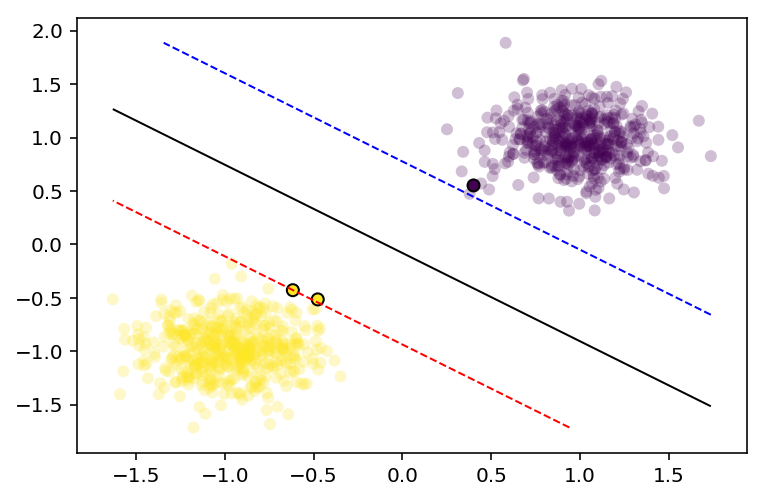

In [17]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

The circled points are our support vectors. They should be the only points with non-zero $\alpha$ values.

In [18]:
output.alphas.sum()

2.193722748483239

Let's see how this model performs with an outlier.

In [19]:
# Add an outlier
X_outlier = np.append(X_train_scaled, [0.1, 0.1])
X_outlier = X_outlier.reshape(X_train.shape[0]+1, X_train.shape[1])
y_outlier = np.append(y, 1)

In [20]:
# Set model parameters and initial values
C = 1000.0
m = len(X_outlier)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

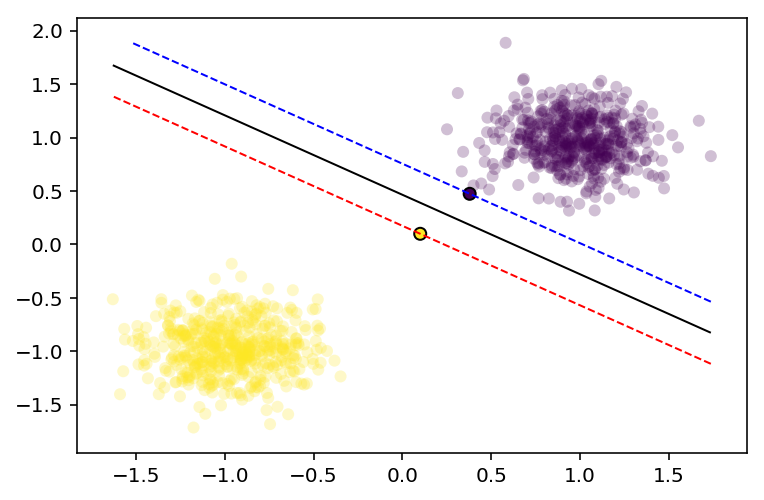

In [21]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

#### What about regularization?

We can see above that a single outlier pushes the decision boundary much farther away from the rest of the population. We can eliminate this effect if we use a softer margin (a lower value for $C$).

In [22]:
# Set model parameters and initial values
C = 1.0

initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

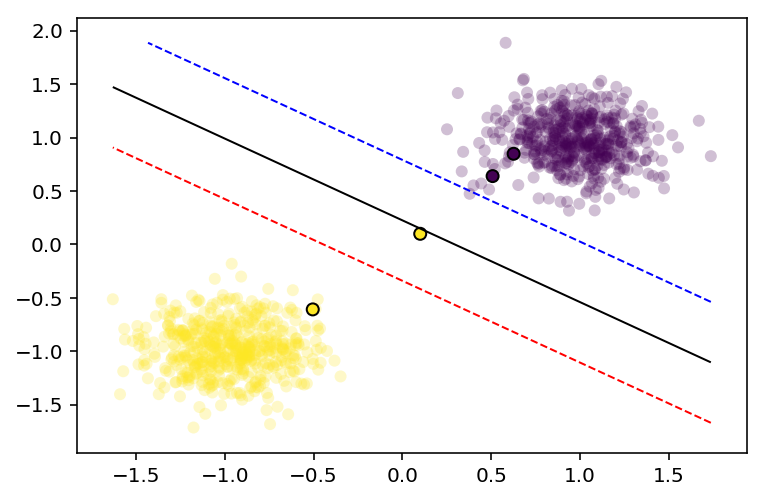

In [23]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

Now the outlier won't influence our decision boundary as much.

### Trying out the Gaussian kernel

Let's try out our Gaussian kernel on some data that can't be separated by a linear decision boundary, such as that generated by scikit-learn's [`make_circles`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html).

In [24]:
X_train, y = make_circles(n_samples=500, noise=0.1,
                          factor=0.1,
                          random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1

In [25]:
# Set model parameters and initial values
C = 1.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_train_scaled, y, C, gaussian_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

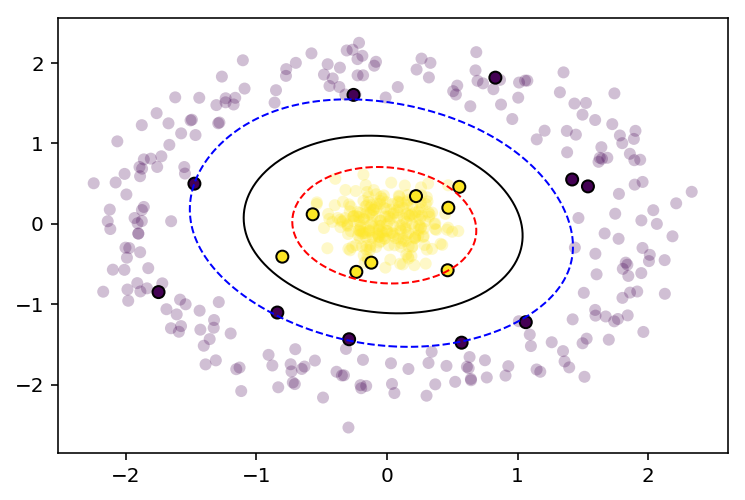

In [26]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

How about [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)?

In [27]:
X_train, y = make_moons(n_samples=500, noise=0.1,
                        random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1

In [28]:
# Set model parameters and initial values
C = 1.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_train_scaled, y, C, lambda x, y: gaussian_kernel(x, y, sigma=0.5),
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

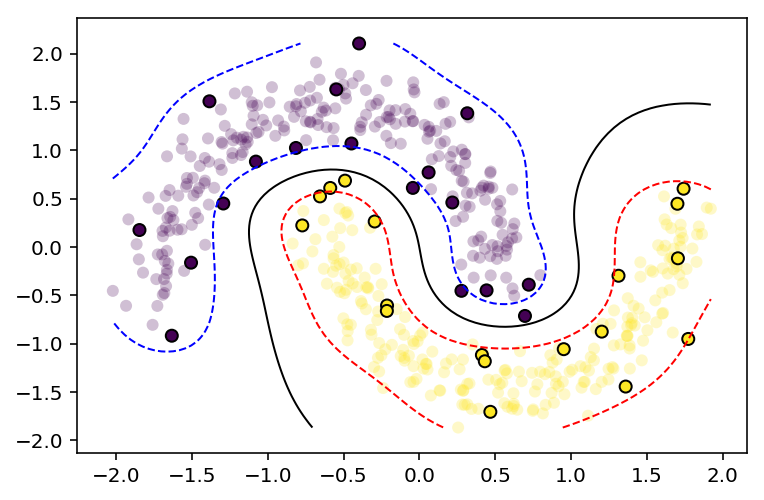

In [29]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

How about that, we've got ourselves a non-linear decision boundary! It's not perfect but this illustrates the power of the kernel trick using SVMs -- we were able to achieve a complex boundary simply by using a different feature mapping.

### Conclusion

We have successfully implemented a rudimentary version of the sequential minimal optimization algorithm for solving the dual form of the general SVM optimization problem. We were also able to illustrate the 'kernel trick', which is part of what makes SVMs such a powerful tool in machine learning. We were also able to introduce regularization into our model via the $C$ parameter. This helps our model generalize to new, unseen data.